# Project 1

**Note**: if you feel like your Pandas skills need a bit of a touch up, check [this article out](https://levelup.gitconnected.com/20-pandas-functions-for-80-of-your-data-science-tasks-b610c8bfe63c)!

The dataset we're going to be using is one of the most realistic retail time-series datasets you'll find out there because, well, it's actual Walmart data. It was made available for a Kaggle competition that you can check out [here](https://www.kaggle.com/c/m5-forecasting-accuracy).

The original format of the data was in a "wide" format to made it smaller in memory, but that doesn't really work too well with databases and you won't see that very often in the real world. The most notable changes are that I added in a date column to replace the date identifier columns that were previously there, and I made the data smaller by only subsetting to the state of Texas.

**Another note:** If you want to develop and test your code with a smaller dataset (which I'd probably recommend), set `sampled` in the cell below to `True`. All of the tests will still pass if your code is correct!

Let's get into it!

In [1]:
data_dir = '/kaggle/input/week1-dataset/data'
sampled = False

path_suffix = '' if not sampled else '_sampled'

In [2]:
import pandas as pd
import numpy as np

## Getting our data in the right format

Time-series data has to be collected from some real-world, data-generating process. That means that raw data comes in as a series of observations. Depending on your experience with time-series data, you may be used to data that looks like this:

| Date       | Sales |
|------------|-------|
| 2022-01-01 |  23   |
| 2022-01-02 |  45   |
| 2022-01-03 |  12   |
| 2022-01-04 |  67   |
| 2022-01-05 |  89   |

But, if you're in retail, each of those "sales" probably came in some JSON from some point-of-sale system (i.e. cash register) that probably looked something like this:

```
{
    "timestamp": 2022-01-01 12:34:56,
    "product_id": 5,
    "store_id": 12,
    "category_id": 36,
    ...
}
```

Usually, it's the job of a data engineer to collect all of these records and aggregate them into a nice, tabular format, but it's worth at least having an appreciation for how it's done. So, we're going to start from a mock version of a transactions table.

In [3]:
transactions = pd.read_csv(f'{data_dir}/transactions_data{path_suffix}.csv')

transactions.head()

,date,id,item_id,dept_id,cat_id,store_id,state_id
0,2013-01-01 13:41:03,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
1,2013-01-01 07:30:52,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
2,2013-01-01 11:17:38,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
3,2013-01-01 20:18:59,HOBBIES_1_025_TX_1_evaluation,HOBBIES_1_025,HOBBIES_1,HOBBIES,TX_1,TX
4,2013-01-01 21:36:09,HOBBIES_1_028_TX_1_evaluation,HOBBIES_1_028,HOBBIES_1,HOBBIES,TX_1,TX


In [4]:
transactions.dtypes

date        object
id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
state_id    object
dtype: object

You can see that this is a DataFrame where each row relates to purchases for an individual item. Here's a little data dictionary:

- `date`: the time at which an item was bought, down to the second
- `id`: the product ID. Each of these is an individual item at a specific store.
- `item_id`: this is an identifier for items, but not at the store level. You can use this to find the same item at different stores.
- `dept_id`: department ID. One level up from `item_id` in the hierarchy
- `cat_id`: category ID. One level up from `dept_id` in the hierarchy
- `store_id`: identifies the specific store where the product was bought
- `state_id`: identifies the specific state where the product was bought

`date` is supposed to be a `datetime`-like object, but you can see that when we loaded it from disk, it was loaded in as a string. Let's convert that column to `datetime`.

In [5]:
# QUESTION: Convert this column to a datetime object
transactions['date'] = pd.to_datetime(transactions['date'])

Our goal is to transform this dataset into one that's easy to analyze and train models on. For this project, our goal is going to be to work at the daily level. So, our first step is to aggregate our transactions data up to the daily level.

To be more specific, this is what we want it to look like:

In [6]:
# This is a hefty table, so just peeking at the first 5 rows
pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', nrows=5)

,date,id,item_id,dept_id,cat_id,store_id,state_id,sales
0,2013-01-01,HOBBIES_1_001_TX_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0
1,2013-01-01,HOBBIES_1_002_TX_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,TX_1,TX,0
2,2013-01-01,HOBBIES_1_003_TX_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,TX_1,TX,0
3,2013-01-01,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX,3
4,2013-01-01,HOBBIES_1_005_TX_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,TX_1,TX,0


You can see that the `sales` column is really just a daily count of transactions for that particular `id`.

In the cell below, create a dataframe called `data`, which is the transactions dataframe aggregated to the daily level. It should look like the above, except you won't have zero sales days. Don't worry about order: the below test will handle that!

In [7]:
daily_grouper = pd.Grouper(key='date', freq='D')
columns = [daily_grouper, 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
data = (
    transactions
    .groupby(columns, as_index=False)
    .size()
    .rename({"size": "sales"}, axis=1)
)
data.head()

,date,id,item_id,dept_id,cat_id,store_id,state_id,sales
0,2013-01-01,FOODS_1_004_TX_1_evaluation,FOODS_1_004,FOODS_1,FOODS,TX_1,TX,20
1,2013-01-01,FOODS_1_004_TX_2_evaluation,FOODS_1_004,FOODS_1,FOODS,TX_2,TX,20
2,2013-01-01,FOODS_1_004_TX_3_evaluation,FOODS_1_004,FOODS_1,FOODS,TX_3,TX,4
3,2013-01-01,FOODS_1_005_TX_2_evaluation,FOODS_1_005,FOODS_1,FOODS,TX_2,TX,1
4,2013-01-01,FOODS_1_009_TX_2_evaluation,FOODS_1_009,FOODS_1,FOODS,TX_2,TX,3


If the cell below runs without error, you did it right!

In [8]:
def test_sales_eq(data):
    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'])
        .assign(date=lambda df: pd.to_datetime(df.date))
        .query('sales != 0')
        .merge(data, on=['date', 'id'], how='left', suffixes=('_actual', '_predicted'))
        .fillna(0)
        .assign(sales_error=lambda df: (df.sales_actual - df.sales_predicted).abs())
        .sales_error
        .sum() < 1e-6
    ), 'Your version of sales does not match the original sales data.'

    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'])
        .query('sales != 0')
        .shape[0]
    ) == data.shape[0], 'Your dataframe has a different number of rows than the original sales data.'

test_sales_eq(data)

## Optimizing our data

Let's take a look at how our data is being stored in memory.

In [9]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895938 entries, 0 to 3895937
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      datetime64[ns]
 1   id        object        
 2   item_id   object        
 3   dept_id   object        
 4   cat_id    object        
 5   store_id  object        
 6   state_id  object        
 7   sales     int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 1.5 GB


1.5 GB of data for our purposed is certainly no joke. But how much of that is really necessary?

Most of our data is stored in the least memory efficient format for pandas: strings (objects). Let's fix that.

Hint: check out [this page](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes) of the pandas documentation that talks about data types.

In the below cell, convert the data types of columns to reduce memory usage as much as possible.

In [10]:
CATEGORY_COLUMNS = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
data[CATEGORY_COLUMNS] = data[CATEGORY_COLUMNS].astype('category')
data['sales'] = data['sales'].astype(np.uint16)

In [11]:
# Takes a long time to run on whole dataset
# (data.date.max() - data.date.min()).days

As you can see we have only 1237 days range in our dataset, which means that the `sales` count cannot go over 1237. Knowing that, and knowing that obviously it cannot go negative either, this is why I am using a UInt16 for `sales`

In [12]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895938 entries, 0 to 3895937
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      datetime64[ns]
 1   id        category      
 2   item_id   category      
 3   dept_id   category      
 4   cat_id    category      
 5   store_id  category      
 6   state_id  category      
 7   sales     uint16        
dtypes: category(6), datetime64[ns](1), uint16(1)
memory usage: 68.1 MB


In my solution, I got the final DataFrame down to 90.4 MB, which is about 6% of the original size!

While we're at it, it's worth talking about the best way to store this data on disk. If we saved this as a CSV, it wouldn't maintain any of the data type modifications we just made. Pandas offers a bunch of options for saving DataFrames, but here are the two I'd recommend:

- [Parquet](https://pandas.pydata.org/docs/dev/reference/api/pandas.DataFrame.to_parquet.html) has basically become the industry standard for storing tabular data on disk. It's a columnar file format that automatically compresses your data (which it does really well) and will maintain any data types you use in Pandas, with only a couple exceptions.

- [Feather](https://pandas.pydata.org/docs/dev/reference/api/pandas.DataFrame.to_parquet.html) is also a columnar data format, but it optimizes heavily for read speed. Your file size will be much bigger than Parquets, but it's really useful when you need to heavily optimize for data reading.

In [13]:
import os

os.mkdir('data')

In [14]:
data.to_parquet('data/sales_data_checkpoint.parquet')

In [15]:
data = pd.read_parquet('data/sales_data_checkpoint.parquet')

In [16]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3895938 entries, 0 to 3895937
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      datetime64[ns]
 1   id        category      
 2   item_id   category      
 3   dept_id   category      
 4   cat_id    category      
 5   store_id  category      
 6   state_id  category      
 7   sales     uint16        
dtypes: category(6), datetime64[ns](1), uint16(1)
memory usage: 68.1 MB


On my local machine, loading our original CSV took ~8.7 seconds, and that only took 0.1 seconds. And our data types were maintained! Nice!

## Finishing up our data pre-processing

There's one last modification we need to make to our data before it's ready to go. The way that we converted transactions into sales was *slightly* problematic because now, when a product doesn't sell it just isn't present in our data, rather than appearing as a zero. 

That's an issue for our forecasting models, so let's fix it!

First, set your index to columns that the DataFrame is distinct on (`date` and `id`).

In [17]:
data = data.set_index(['date', 'id'])

In [18]:
data.head()

item_id  dept_id cat_id store_id  \
date       id                                                                  
2013-01-01 FOODS_1_004_TX_1_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_1   
           FOODS_1_004_TX_2_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_2   
           FOODS_1_004_TX_3_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_3   
           FOODS_1_005_TX_2_evaluation  FOODS_1_005  FOODS_1  FOODS     TX_2   
           FOODS_1_009_TX_2_evaluation  FOODS_1_009  FOODS_1  FOODS     TX_2   

                                       state_id  sales  
date       id                                           
2013-01-01 FOODS_1_004_TX_1_evaluation       TX     20  
           FOODS_1_004_TX_2_evaluation       TX     20  
           FOODS_1_004_TX_3_evaluation       TX      4  
           FOODS_1_005_TX_2_evaluation       TX      1  
           FOODS_1_009_TX_2_evaluation       TX      3

Now, create a MultiIndex with all combinations of daily dates and `id`s using `pd.MultiIndex.from_product`

In [19]:
min_date, max_date = data.index.get_level_values('date').min(), data.index.get_level_values('date').max()
dates_to_select = pd.date_range(min_date, max_date, freq='1D')
unique_product_ids = data.index.get_level_values('id').unique()

index_to_select = pd.MultiIndex.from_product(
    [dates_to_select, unique_product_ids],
    names=['date', 'id']
)
data = (
    data
    .reindex(index=index_to_select, copy=False)
    .reset_index()
)

In [20]:
data.head()

,date,id,item_id,dept_id,cat_id,store_id,state_id,sales
0,2013-01-01,FOODS_1_004_TX_1_evaluation,FOODS_1_004,FOODS_1,FOODS,TX_1,TX,20.0
1,2013-01-01,FOODS_1_004_TX_2_evaluation,FOODS_1_004,FOODS_1,FOODS,TX_2,TX,20.0
2,2013-01-01,FOODS_1_004_TX_3_evaluation,FOODS_1_004,FOODS_1,FOODS,TX_3,TX,4.0
3,2013-01-01,FOODS_1_005_TX_2_evaluation,FOODS_1_005,FOODS_1,FOODS,TX_2,TX,1.0
4,2013-01-01,FOODS_1_009_TX_2_evaluation,FOODS_1_009,FOODS_1,FOODS,TX_2,TX,3.0


Finally, fill the resulting `NaN`s in your dataframe. Hint: it's tempting to use `.groupby().fillna(method='ffill')` (and backfilling), but unfortunately this method is quite slow on grouped data. I'd recommend manually recreating the categorical columns by splitting the `id` column on underscores. This cell could take over a minute to run depending on how you implement it!

In [21]:
split_id_df = data.id.str.split('_', expand=True)
mask_nan = data.isna().any(axis=1)
data[mask_nan] = data[mask_nan].assign(
    item_id=[f"{x}_{y}_{z}" for x, y, z in zip(split_id_df.loc[mask_nan, 0], split_id_df.loc[mask_nan, 1], split_id_df.loc[mask_nan, 2])],
    dept_id=[f"{x}_{y}" for x, y in zip(split_id_df.loc[mask_nan, 0], split_id_df.loc[mask_nan, 1])],
    cat_id=split_id_df.loc[mask_nan, 0],
    store_id=[f"{x}_{y}" for x, y in zip(split_id_df.loc[mask_nan, 3], split_id_df.loc[mask_nan, 4])],
    state_id=split_id_df.loc[mask_nan, 3],
).fillna({'sales': 0})

In [22]:
def test_sales_eq(data):
# I modify a little bit the test code, just so that it makes sense with my data
#     data_copy = (
#         data
#         .copy()
#         .reset_index('id')
#         .assign(id=lambda df: df.id.astype(str).values)
#     )
    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'])
        .query('id != "FOODS_2_394_TX_3_evaluation"')  # this item is missing in my modified data
        .assign(date=lambda df: pd.to_datetime(df.date))
        .merge(
            data, 
            on=['date', 'id'], 
            how='left', 
            suffixes=('_actual', '_predicted')
        )
        .fillna({'sales_actual': 0, 'sales_predicted': 0})
        .assign(sales_error=lambda df: (df.sales_actual - df.sales_predicted).abs())
        .sales_error
        .sum() < 1e-6
    ), 'Your version of sales does not match the original sales data.'

test_sales_eq(data)

## Exploring our data

Exploratory data analysis is crucial for building the best models.

Before you start this section, though, I would **highly recommend** that you set the index of your DataFrame to be on both the `date` and `id` field (our DataFrame has one row for each `date`/`id` combo). It's up to you, but it's good practice!

For this section, find 3-5 insights about the data that you feel are helpful for building models. Specifically, we'll be building models at the `date`/`dept_id` level (i.e., a forecast for `FOODS_1` on 2011-02-01, 2011-02-02, etc., a forecast for `HOBBIES_1` on 2011-02-01, 2011-02-02, etc.)

The only required one is an [autocorrelation analysis](https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html). Other than that, some ideas are:

- Looking for seasonal patterns and trends for each department
- Department sales by day of week
- Analyses at a higher level, like the category level

Anything goes! Be creative!

Here's an example of plotting the category-level sales for `FOODS_1` to get you started:

```
(
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'FOODS_1']
    .plot()
)
```

In [23]:
import matplotlib.pyplot as plt

In [24]:
data = data.set_index(['date', 'id'])
data.head()

item_id  dept_id cat_id store_id  \
date       id                                                                  
2013-01-01 FOODS_1_004_TX_1_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_1   
           FOODS_1_004_TX_2_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_2   
           FOODS_1_004_TX_3_evaluation  FOODS_1_004  FOODS_1  FOODS     TX_3   
           FOODS_1_005_TX_2_evaluation  FOODS_1_005  FOODS_1  FOODS     TX_2   
           FOODS_1_009_TX_2_evaluation  FOODS_1_009  FOODS_1  FOODS     TX_2   

                                       state_id  sales  
date       id                                           
2013-01-01 FOODS_1_004_TX_1_evaluation       TX   20.0  
           FOODS_1_004_TX_2_evaluation       TX   20.0  
           FOODS_1_004_TX_3_evaluation       TX    4.0  
           FOODS_1_005_TX_2_evaluation       TX    1.0  
           FOODS_1_009_TX_2_evaluation       TX    3.0

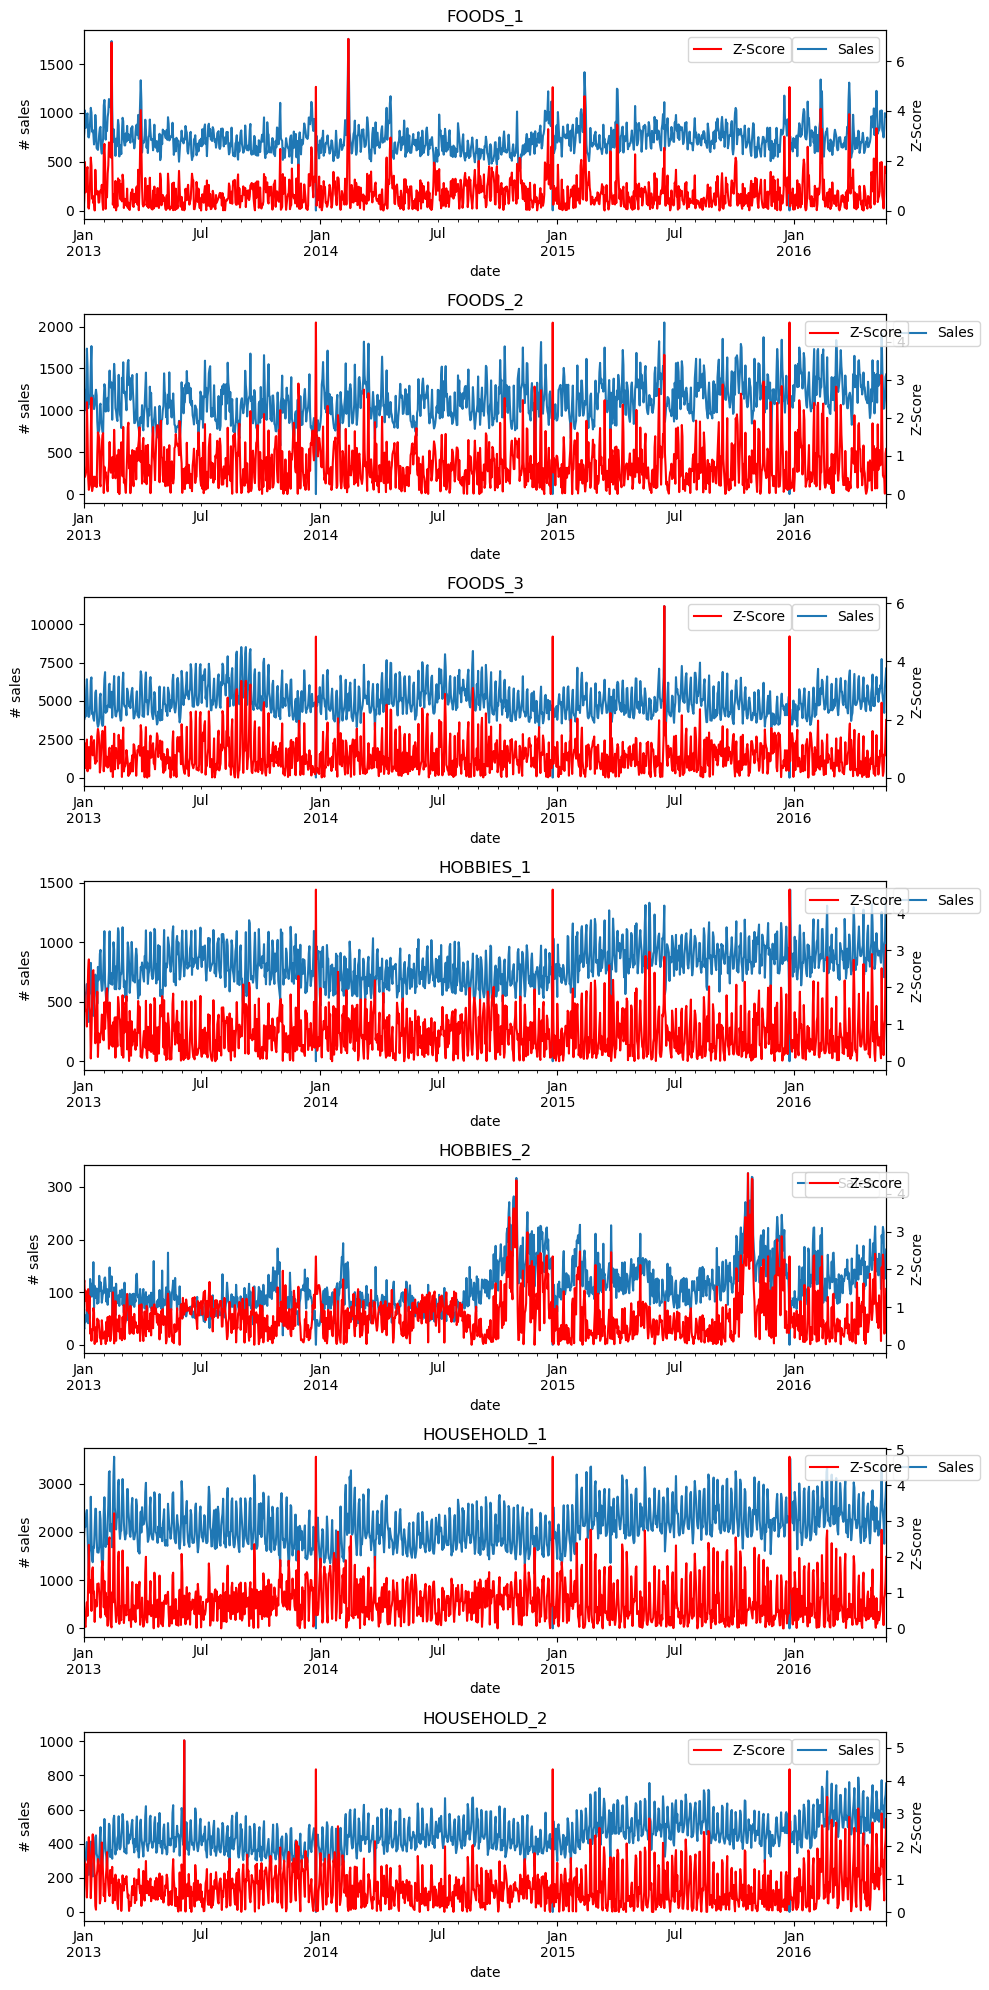

In [25]:
from scipy.stats import zscore

grouped = data.groupby(['date', 'dept_id']).sales.agg('sum')
unique_dept_id = grouped.index.get_level_values(1).unique()

fig, axs = plt.subplots(len(unique_dept_id), 1, figsize=(10, 20))

# iterate over the departments and plot the sales over time
for i, dept_id in enumerate(unique_dept_id):
    zscore_arr = np.abs(zscore(grouped.loc[:, dept_id]))
    ax = axs[i]
    ax2 = ax.twinx()
    grouped.loc[:, dept_id].plot(y='sales', ax=ax, label='Sales')
    ax2.plot(zscore_arr, color='red', label='Z-Score')
    ax.set_ylabel('# sales')
    ax2.set_ylabel('Z-Score')
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    ax2.legend(bbox_to_anchor=(0.89, 1.0))
    ax.set_title(dept_id)

plt.tight_layout()
plt.show()

We can see that some points appear as clear outliers in their distributions. It could be interesting too see if ommiting them and replacing their values could improve the overall model

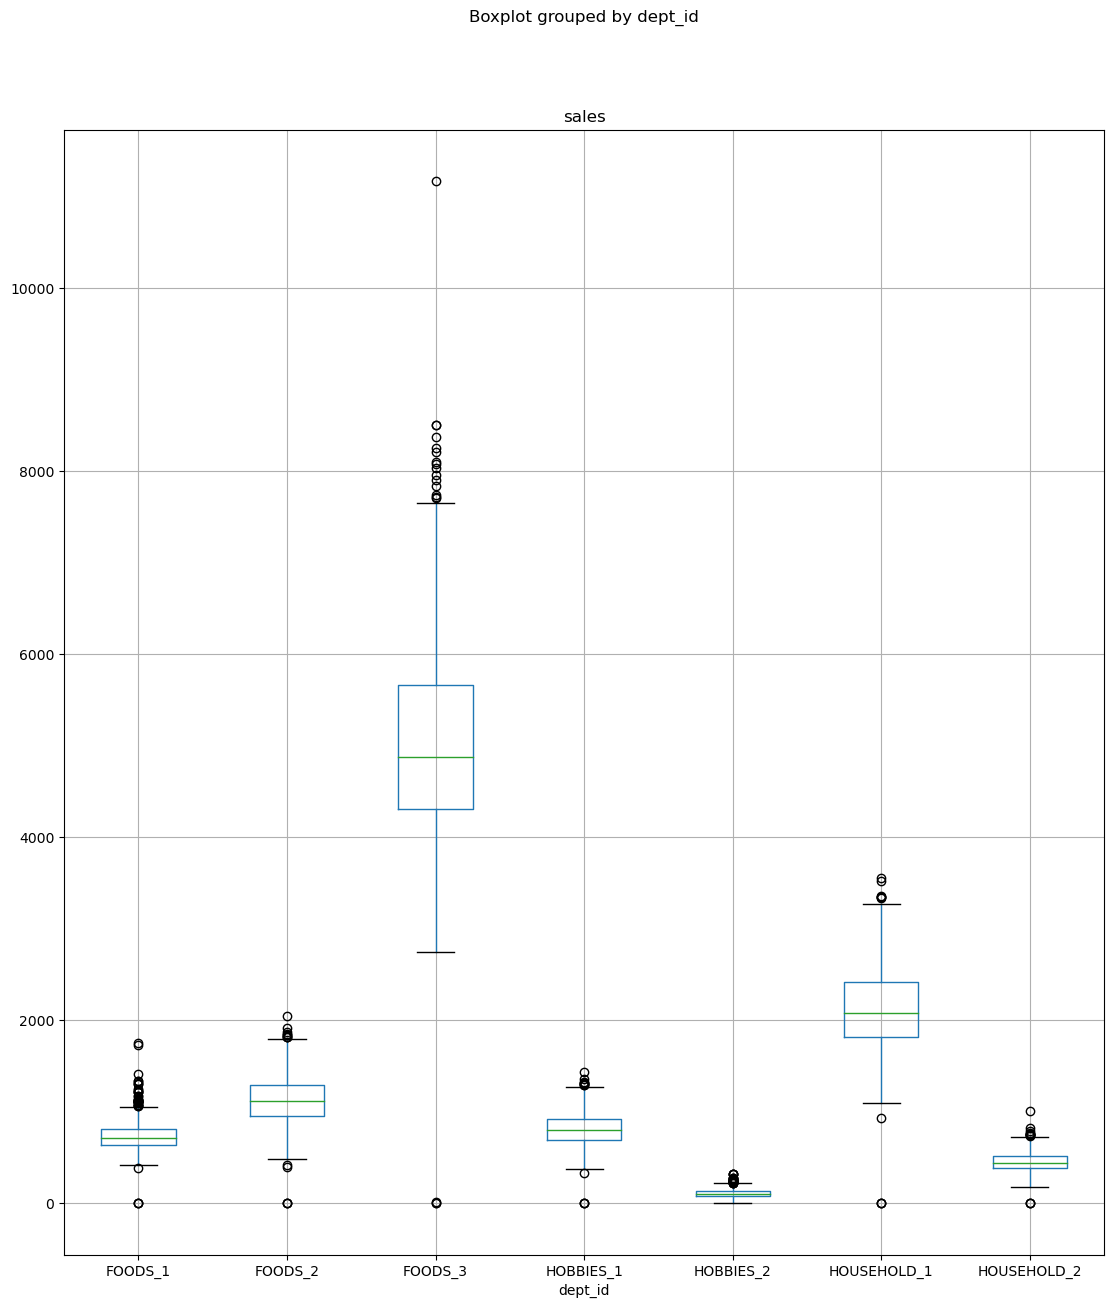

In [26]:
grouped = data.groupby(['date', 'dept_id']).sales.agg('sum').reset_index(level=1)

grouped.boxplot(column='sales', by='dept_id', figsize=(13, 15))
plt.show()

Our time series have different distributions, `FOODS_3` is significantly higher for instance. Knowing that, it could be interesting to scale our different time series so that the model does not struggle with different order of magnitudes induced by the difference in departments.

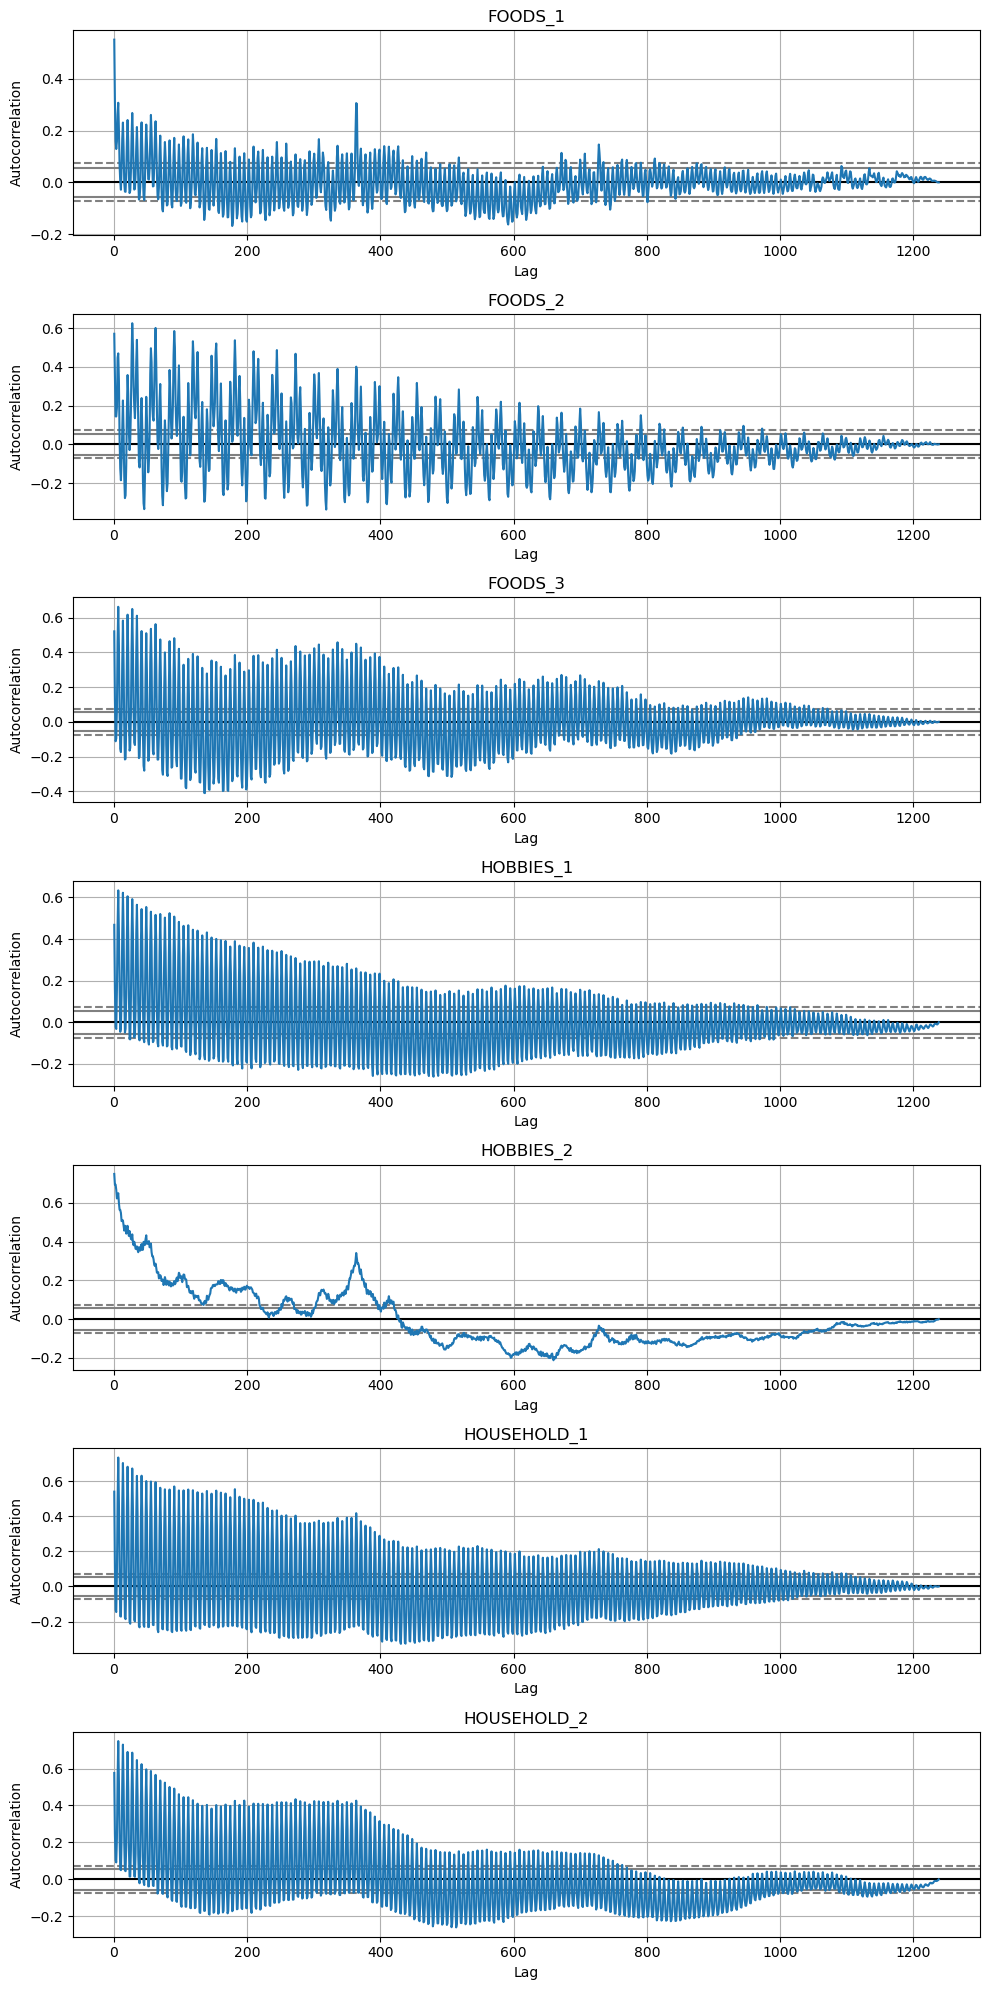

In [27]:
grouped = data.groupby(['date', 'dept_id']).sales.agg('sum')
unique_dept_id = grouped.index.get_level_values(1).unique()

fig, axs = plt.subplots(len(unique_dept_id), 1, figsize=(10, 20))

# iterate over the departments and plot the sales over time
for i, dept_id in enumerate(unique_dept_id):
    ax = axs[i]
    pd.plotting.autocorrelation_plot(grouped.loc[:, dept_id], ax=ax)
    ax.set_title(dept_id)
    
plt.tight_layout()
plt.show()

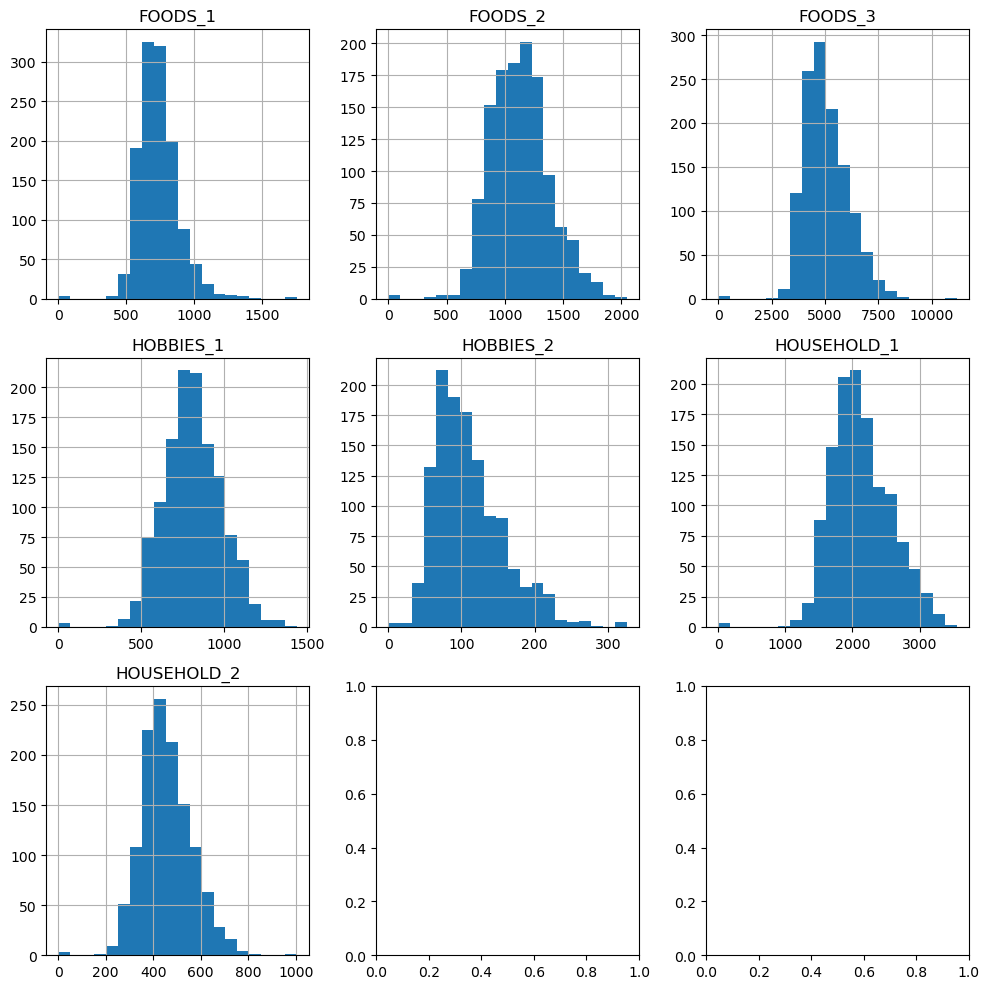

In [28]:
grouped = data.groupby(['date', 'dept_id']).sales.agg('sum')
unique_dept_id = grouped.index.get_level_values(1).unique()

fig, axs = plt.subplots(len(unique_dept_id) // 3 + 1, 3, figsize=(10, 10))

# iterate over the departments and plot the sales over time
for i, dept_id in enumerate(unique_dept_id):
    ax = axs[i // 3, i % 3]
    grouped.loc[:, dept_id].hist(ax=ax, bins=20)
    ax.set_title(dept_id)
    
plt.tight_layout()
plt.show()

This plotting is here specifically to test the assumption that all our time series are normally distributed. It is important to test it in order to apply a standard scaler afterwards. The only thing making me doubt here is that some distributions have a gap between 0s and other positive values, like `HOUSEHOLD_1`. This might be a problem that there is a discontinuity... 

## Training some models!

Finally, we can train some models!

We're going to use the [statsforecast](https://github.com/Nixtla/statsforecast) library, since it makes training statistical time-series models really easy. There are other great libraries (like [darts](https://unit8co.github.io/darts/), which is more mature of a package) but I like `statsforecast` a bit more for these models. Eventually, we'll get to training our own models from scratch.

Here's what you need to do:

1. Aggregate sales up to the `date`/`dept_id` level so each date has 7 distinct records (one for each `dept_id`).
2. Convert your aggregated data into the [format that `statsforecast` likes](https://nixtla.github.io/statsforecast/examples/getting_started_short.html).
3. Fit and evaluate some models! This part is made straightforward by `statsforecast` so feel free to fit whatever you want, but focus on models like [this one](https://nixtla.github.io/statsforecast/models.html#arima-family) and [this one](https://nixtla.github.io/statsforecast/models.html#holt-winters-method) since we discussed them. Their documentation has a [quickstart](https://nixtla.github.io/statsforecast/examples/getting_started_short.html) to get going. I provided you with some helper code below to get started.
    - Play around with `ARIMA` and `HoltWinters` and tune them using your intution, then compare them to [`AutoARIMA`](https://nixtla.github.io/statsforecast/models.html#autoarima) and [`AutoETS`](https://nixtla.github.io/statsforecast/models.html#autoets), which do the tuning for you!
4. (If your time permits) try out other libraries! Go try to fit a [Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) model, fit some models using `darts` and see how they compare, etc.

In [29]:
# Don't worry about any error outputs you see from this
! pip install statsforecast==1.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.8/187.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.1/185.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 k

In [30]:
from statsforecast import StatsForecast
from statsforecast.models import ARIMA, HoltWinters, AutoARIMA, AutoETS

/opt/conda/lib/python3.7/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [31]:
# Aggregate data to date/dept_id level

train_data = data.groupby(['date', 'dept_id']).sales.agg('sum').reset_index()
train_data.head()

,date,dept_id,sales
0,2013-01-01,FOODS_1,727.0
1,2013-01-01,FOODS_2,892.0
2,2013-01-01,FOODS_3,4230.0
3,2013-01-01,HOBBIES_1,412.0
4,2013-01-01,HOBBIES_2,37.0


In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import zscore

timestamp_train_limit = pd.Timestamp('2016-04-24')

scaler = MinMaxScaler()
scaler = None

train_df = (
    train_data
    .rename(columns={'dept_id': 'unique_id', 'date': 'ds', 'sales': 'y'})
    .query('ds < @timestamp_train_limit')
    .assign(
        z_score=lambda x: x.groupby('unique_id')['y'].transform(zscore),
        y_filtered=lambda x: np.where((x['z_score'] > 3.5), np.nan, x['y']),
        y_ffill=lambda x: x.groupby('unique_id')['y_filtered'].fillna(method='ffill'),
        y=lambda x: scaler.fit_transform(x['y_ffill'].values.reshape(-1, 1)).reshape(-1) if scaler else x['y_ffill']
    )
    [['ds', 'unique_id', 'y']]
)


sf = StatsForecast(
    models=[
        # SARIMA(1, 1, 1)(1, 1, 1),7
        ARIMA(order=(1, 1, 2), seasonal_order=(2, 1, 2), season_length=7),
        # ETS model
        HoltWinters(season_length=7),
        #AutoARIMA
        AutoARIMA(season_length=7),
        # AutoETS
        AutoETS(season_length=7),
    ],
    freq='D'
)
sf.fit(train_df)

StatsForecast(models=[ARIMA,HoltWinters,AutoARIMA,AutoETS])

In [33]:
forecast_df = sf.predict(h=29)
forecast_df.tail()

,ds,ARIMA,HoltWinters,AutoARIMA,AutoETS
unique_id,,,,,
HOUSEHOLD_2,2016-05-18,512.027466,499.020599,486.662506,497.293274
HOUSEHOLD_2,2016-05-19,528.196045,515.556763,528.075378,514.259827
HOUSEHOLD_2,2016-05-20,566.823303,558.914246,544.777954,557.081726
HOUSEHOLD_2,2016-05-21,678.365601,663.538147,690.452087,662.138611
HOUSEHOLD_2,2016-05-22,671.300232,657.626465,693.833374,656.109192


In [34]:
(
    forecast_df
    .merge(
        train_data.rename(columns={'dept_id': 'unique_id', 'date': 'ds', 'sales': 'y'}),
        how="inner",
        on=["unique_id", "ds"]
    )
    .assign(
        ARIMA=lambda x: scaler.inverse_transform(x['ARIMA'].values.reshape(-1, 1)).reshape(-1) if scaler else x['ARIMA'],
        HoltWinters=lambda x: scaler.inverse_transform(x['HoltWinters'].values.reshape(-1, 1)).reshape(-1) if scaler else x['HoltWinters']
    )
    .pipe(lambda x: x.assign(
        ARIMA_MAE=np.abs(x['y'] - x['ARIMA']),
        HoltWinters_MAE=np.abs(x['y'] - x['HoltWinters'])
    ))
    .pipe(lambda x: print(f"Mean Absolute Error for ARIMA: {np.mean(x['ARIMA_MAE'])}\nMean Absolute Error for HoltWinters: {np.mean(x['HoltWinters_MAE'])}"))
)


Mean Absolute Error for ARIMA: 163.7382078875462
Mean Absolute Error for HoltWinters: 185.74931681214883


## ARIMA with parameters (1, 1, 1) / (1, 1, 1) / 7
Baseline model:
```
Mean Absolute Error for ARIMA: 177.593322378074
Mean Absolute Error for HoltWinters: 185.7137790924223
```

Baseline model with StandardScaler:
```
Mean Absolute Error for ARIMA: 177.44612655263816
Mean Absolute Error for HoltWinters: 183.82465035574776
```

Baseline model with StandardScaler + Z-Score pruning:
```
Mean Absolute Error for ARIMA: 177.44612655263816
Mean Absolute Error for HoltWinters: 183.82465035574776
```

Baseline model with MinMaxScaler + Z-Score pruning:
```
Mean Absolute Error for ARIMA: 180.11170632498602
Mean Absolute Error for HoltWinters: 189.0460320834456
```

Baseline model with Z-Score pruning:
```
Mean Absolute Error for ARIMA: 179.51491572939113
Mean Absolute Error for HoltWinters: 186.9012638336332
```

## ARIMA with parameters (1, 1, 2) / (2, 1, 2) / 7
#### _Params given by grid search below_
Baseline model:
```
Mean Absolute Error for ARIMA: 166.71101056178802
Mean Absolute Error for HoltWinters: 185.71377909242227
```

Baseline model with StandardScaler:
```
Mean Absolute Error for ARIMA: 165.0593375971752
Mean Absolute Error for HoltWinters: 183.82465035574776
```

Baseline model with StandardScaler + Z-Score pruning:
```
Mean Absolute Error for ARIMA: 166.29549471850467
Mean Absolute Error for HoltWinters: 186.3315859639586
```

Baseline model with MinMaxScaler + Z-Score pruning:
```
Mean Absolute Error for ARIMA: 168.1073737684729
Mean Absolute Error for HoltWinters: 185.74932199863377
```

Baseline model with Z-Score pruning:
```
Mean Absolute Error for ARIMA: 163.7382078875462
Mean Absolute Error for HoltWinters: 185.74931681214883
```

These are `plotly` charts, which are interactive. If you're not familiar, you can:
- Click a series name in the legend (on the right) to activate/deactivate it in the plots
- Hover your mouse over the plots and click + drag to zoom in
- Double click on the plots to zoom back out

In [35]:
sf.plot(train_data.rename(columns={'dept_id': 'unique_id', 'date': 'ds', 'sales': 'y'}), forecast_df)

In [36]:
import traceback
from itertools import product
from sklearn.metrics import mean_absolute_error

class ARIMAGridSearch:
    def __init__(self, data, timestamp_limit, p_values, d_values, q_values, seasonal_p_values=None, seasonal_d_values=None,
                 seasonal_q_values=None, season_length=None, scaler = None):
        self.train_data = data[data.ds < timestamp_limit].copy()
        self.test_data = data[data.ds >= timestamp_limit]
        self.p_values = p_values
        self.d_values = d_values
        self.q_values = q_values
        self.seasonal_p_values = seasonal_p_values
        self.seasonal_d_values = seasonal_d_values
        self.seasonal_q_values = seasonal_q_values
        self.season_length = season_length
        self.scaler = scaler
        if self.scaler:
            self.train_data['y'] = scaler.transform(self.train_data['y'].values.reshape(-1, 1)).reshape(-1)
    
    def fit(self):
        best_score = float('inf')
        best_params = None
        for p, d, q, sp, sd, sq in product(
            self.p_values,
            self.d_values,
            self.q_values,
            self.seasonal_p_values,
            self.seasonal_d_values,
            self.seasonal_q_values,
        ):
            arima_model = ARIMA(
                order=(p, d, q),
                seasonal_order=(sp, sd, sq),
                season_length=self.season_length,
            )
            stats_forecast = StatsForecast(
                models=[arima_model],
                freq='D'
            )
            stats_forecast.fit(self.train_data)
            curr_score = self.score_model(stats_forecast)
            if curr_score < best_score:
                best_score = curr_score
                best_params = {
                    'order': (p, d, q),
                    'seasonal_order': (sp, sd, sq),
                    'season_length': self.season_length,
                }
        return best_params
    
    def score_model(self, model):
        forecast_df = model.predict(h=29)
        return (
            forecast_df
            .merge(
                self.test_data,
                how="inner",
                on=["unique_id", "ds"]
            )
            .assign(
                ARIMA=lambda x: self.scaler.inverse_transform(x['ARIMA'].values.reshape(-1, 1)).reshape(-1) if self.scaler else x['ARIMA']
            )
            .pipe(lambda x: x.assign(
                ARIMA_MAE=np.abs(x['y'] - x['ARIMA'])
            ))
            .pipe(lambda x: np.mean(x['ARIMA_MAE']))
        )



arima_grid_search = ARIMAGridSearch(data=train_data.rename(columns={'dept_id': 'unique_id', 'date': 'ds', 'sales': 'y'}),
                                    timestamp_limit='2016-04-24',
                                    p_values=[1, 2],
                                    d_values=[1, 2],
                                    q_values=[1, 2],
                                    seasonal_p_values=[1, 2],
                                    seasonal_d_values=[1, 2],
                                    seasonal_q_values=[1, 2],
                                    season_length=7,
                                    scaler=scaler)

# Uncomment if you wanna try the grid search, but be aware it can ramp up to a 
# pretty long time of computing
best_params = arima_grid_search.fit()
print("Best params:", best_params)

/opt/conda/lib/python3.7/site-packages/statsforecast/arima.py:1162: RuntimeWarning:

invalid value encountered in sqrt

/opt/conda/lib/python3.7/site-packages/statsforecast/arima.py:1162: RuntimeWarning:

invalid value encountered in sqrt

/opt/conda/lib/python3.7/site-packages/statsforecast/arima.py:1162: RuntimeWarning:

invalid value encountered in sqrt

/opt/conda/lib/python3.7/site-packages/statsforecast/arima.py:1162: RuntimeWarning:

invalid value encountered in sqrt

/opt/conda/lib/python3.7/site-packages/statsforecast/arima.py:1162: RuntimeWarning:

invalid value encountered in sqrt

/opt/conda/lib/python3.7/site-packages/statsforecast/arima.py:1162: RuntimeWarning:

invalid value encountered in sqrt

/opt/conda/lib/python3.7/site-packages/statsforecast/arima.py:1162: RuntimeWarning:

invalid value encountered in sqrt

/opt/conda/lib/python3.7/site-packages/statsforecast/arima.py:1162: RuntimeWarning:

invalid value encountered in sqrt

/opt/conda/lib/python3.7/site-packages/s

Best params: {'order': (1, 1, 2), 'seasonal_order': (2, 1, 1), 'season_length': 7}


/opt/conda/lib/python3.7/site-packages/statsforecast/arima.py:1162: RuntimeWarning:

invalid value encountered in sqrt

